# GAN

In [1]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
from tensorflow.keras import models
import time

from IPython import display

In [2]:
import tensorflow as tf

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [6]:
train_images.shape[0]

100

In [5]:
train_images = train_images[:100]

In [7]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [39]:
import tensorflow as tf
from tensorflow.keras import layers # type: ignore

def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Input(shape=(100,)))  # Latent vector (noise)

    # Fully connected layer to project and reshape
    model.add(layers.Dense(7 * 7 * 128, activation='relu'))
    model.add(layers.Reshape((7, 7, 128)))  # Shape becomes 7x7x128

    # Upsample to 14x14
    model.add(layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu'))

    # Upsample to 28x28
    model.add(layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='tanh'))  # Output: 28x28x1
    model.add(layers.Reshape((28, 28, 1)))

    return model


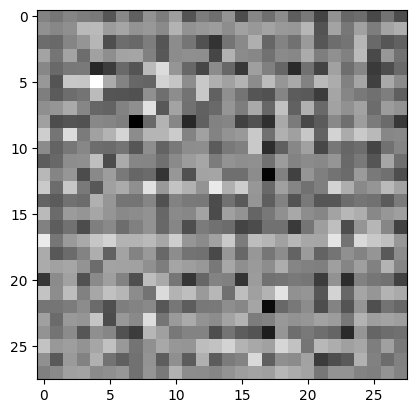

In [36]:
generator = make_generator_model()


noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [38]:
generator.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 6272)           │       633,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 14, 14, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 28, 28, 1)      │           257 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 707,521 (2.70 MB)

 Trainable params: 707,521 (2.70 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:


def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(28,28,1)))
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))

    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model
     


In [13]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00172583]], shape=(1, 1), dtype=float32)


In [14]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:


# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                  discriminator_optimizer=discriminator_optimizer,
#                                  generator=generator,
#                                  discriminator=discriminator)
     


In [20]:
EPOCHS = 2
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [19]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [21]:
def train(dataset,epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

In [ ]:
# generator = models.load_model("trained_models.\\generator.keras")
# discriminator = models.load_model("trained_models.\\discriminator.keras")

In [22]:
train(train_dataset, 1)

In [ ]:
generator.save("trained_models.\\generator.keras")
# discriminator.save("trained_models.\\discriminator.keras")

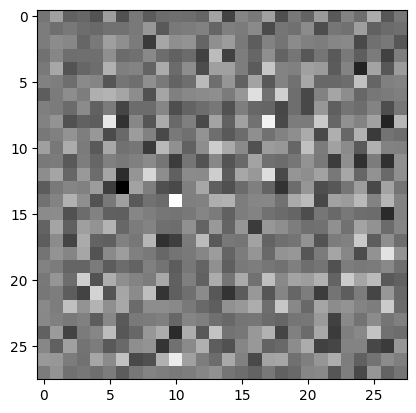

In [25]:
import matplotlib.pyplot as plt
from tensorflow.keras import models
import tensorflow as tf

def generate():
    noise = tf.random.normal([1,100])
    # gen = models.load_model("trained_models.\\generator.keras")
    # gen = models.load_model("trained_models.\\generator.keras")
    # img  = gen(noise,training=False)
    img  = generator(noise,training=False)
    
    display.clear_output(wait=True)
    plt.imshow(img[0,:,:,0],cmap='gray')
    time.sleep(1)
    plt.show()

generate()

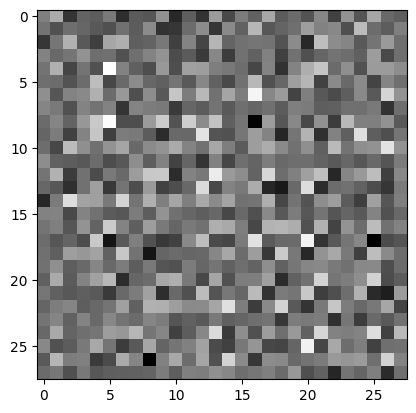

In [27]:
for i in range(10):
    generate()